In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\minorProject\WDSS\jupyter_notebooks
d:\minorProject\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

from typing import List, Tuple, Dict

from config import device, Settings
from commons import initialize

In [3]:
settings = Settings("config/config.json", "WDSSV5")
initialize(settings=settings)

Job: SIREN_FULL_NETWORK, Model: WDSSV5, Device: cuda
Model path: out\SIREN_FULL_NETWORK-WDSSV5\model
Log path: out\SIREN_FULL_NETWORK-WDSSV5\logs


In [4]:
from network.dataset import *

train_dataset, val_dataset, test_dataset = WDSSDatasetCompressed.get_datasets(settings)

In [5]:
from network.models.WDSS import get_wdss_model
    
# Model
model = get_wdss_model(settings.model_config).to(device)

In [6]:
from network.losses import CriterionSSIM_L1

criterion = CriterionSSIM_L1({
    'ssim_image': 0.1,
    'ssim_wavelets': 0.2,
    'l1_image': 0.5,
    'l1_wavelets': 0.5
}).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\weights\v0.1\vgg.pth


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_locatio

In [7]:
from network.trainer import Trainer

trainer = Trainer(settings, model, optimizer, scheduler, criterion, train_dataset, val_dataset, test_dataset)

In [8]:
try:
    trainer.load_best_checkpoint()
    print(f"Checkpoint loaded epoch: {trainer.total_epochs}")
except:
    print("No checkpoint found")

Checkpoint loaded epoch: 3


In [9]:
losses = trainer.get_saved_losses()
print(f"Losses: {losses}")

Losses: ['loss_l1_image_train', 'loss_l1_image_val', 'loss_l1_wavelets_train', 'loss_l1_wavelets_val', 'loss_ssim_image_train', 'loss_ssim_image_val', 'loss_ssim_wavelets_train', 'loss_ssim_wavelets_val', 'loss_total_loss_train', 'loss_total_loss_val', 'loss_train', 'loss_val']


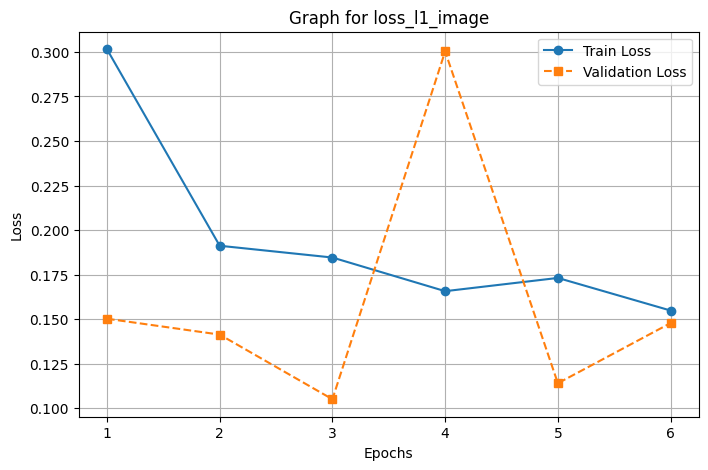

In [16]:
trainer.visualize_losses('loss_l1_image')

In [13]:
p = trainer.get_image_data()

['gt_0',
 'wavelet_gt_0',
 'gt_12',
 'wavelet_gt_12',
 'gt_40',
 'wavelet_gt_40',
 'gt_180',
 'wavelet_gt_180',
 'pred_0',
 'wavelet_pred_0',
 'pred_12',
 'wavelet_pred_12',
 'pred_40',
 'wavelet_pred_40',
 'pred_180',
 'wavelet_pred_180']

No images found for tag 'pred_180' at step 0.


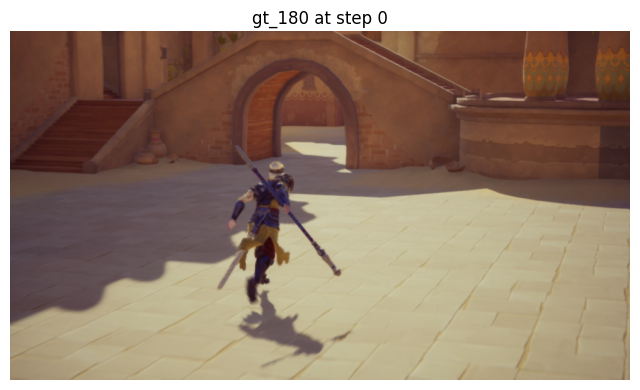

No images found for tag 'wavelet_pred_180' at step 0.
No images found for tag 'pred_180' at step 0.


In [15]:
trainer.visualize_image('pred_180' , 0)
trainer.visualize_image('gt_180' , 0)
trainer.visualize_image('wavelet_pred_180' , 0)
trainer.visualize_image('pred_180' , 0)